# Calculation of COVID-19 Forecast Hub Interval 

Scoring
https://reichlab.io/covid19-forecast-hub/


### Summary of Paper
- Provides scoring function for forecasts consisting of median and predictive intervals. “95 CI that new cases will be between 100 & 150.”
- Used to compare across different forecasts for a given dataset.
- We can compute the complete scoring function by collecting 11 Predictive Intervals and the Median.
- We can compute a subset score using just CI90 & median.
- For point forecasts the score collapses to the absolute error, so we should provide the predictive median.
- For more detailed notes see https://docs.google.com/document/d/1TbUESeqOVO_yEch4j6wHLFu0yxipRuDXr-26hDRcIYo/edit#. There are some good points in the paper about selecting a scoring function that reflects the current need. A model that is bolder (in the right direction) but overconfident (too tight interval) may spur action that is more socially correct than a model that had a lower median, but more likely tail events. No decision is in a vacuum.

### Takeaways for CAN
- The scoring code is not computationally expensive or complicated to write, but may not provide much explainability in our need to look at the performance of a single forecast.
- Given our current focus on point forecasts, this scoring simplifies to the absolute error.
- This scoring would be useful if we want to update our CI policy and need to decide between competing processes for providing confidence intervals.
- Doesn't remove the need to design the test will with a ground truth dataset. For now we have hospitalization and deaths, but how would we test ICU, r(t) etc.


In [10]:
%load_ext autoreload
%autoreload 2
from numpy.random import Generator, PCG64
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rg = np.random.default_rng(12345)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


count    2000.000000
mean       59.474000
std        11.228061
min        26.000000
25%        52.000000
50%        59.000000
75%        66.000000
max       101.000000
dtype: float64
0.00     26.0
0.05     42.0
0.50     59.0
0.95     79.0
1.00    101.0
dtype: float64


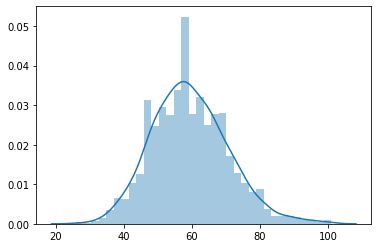

In [11]:
# Create Mock Predictor to Return Quantile Estimates When Asked
prediction_distribution = rg.negative_binomial(60, .5, 2000)
F = pd.Series(prediction_distribution)
print(F.describe())
print(F.quantile([0,0.05,.5,0.95,1]))
sns.distplot(F)

In [12]:
def interval_score(alpha, F, y) -> float:
  """
  This score can be interpreted heuristically as a measure of distance between the predictive
  distribution and the true observation, where the units are similar to those of absolute error,
  on the natural scale of the data.

  It is negatively oriented, meaning a lower score is better.

  See Reich Lab Forecasting Hub preprint "Evaluating epidemic forecasts in an interval format".
  
  Parameters
  ----------
  alpha: float
    Prediction int used to calculate a central (1-alpha)x100% prediction interval. So an alpha of .1
    would be the 90% prediction interval and would use the .05 and .95 quantiles are predictions.
  F: pandas.Series or object with quantile method
    The function to draw quantiles. Can be anything that has a self.quantile method that returns
    a quantile when passed a value in [0,1]
  y: float
    The observed value

  Returns
  -------
  score: float
    The interval score for a given alpha, predictive distribution F, and observed Y. 
  """
  # The score has two main parts. A score for how sharp your estimate is (tighter is better) and a
  # penalty if the observed is outside the estimate. The penalty is proportional to the distance
  # between the estimate and your estimate.

  # First Part: Sharpness Score
  lower_quantile = alpha/2
  upper_quantile = 1-(alpha/2)
  upper_estimate = F.quantile(upper_quantile)
  lower_estimate = F.quantile(lower_quantile)

  range_score = upper_estimate - lower_estimate

  # Second Part: Penality for Observed Outside Predicted Range
  if y >= lower_estimate and y <= upper_estimate:  # Within Range
    penalty = 0
  elif y < lower_estimate:  # Below Range
    penalty = (2/alpha) * (lower_estimate-y)
  else:  # Above Range
    penalty = (2/alpha) * (y-upper_estimate)

  return range_score + penalty


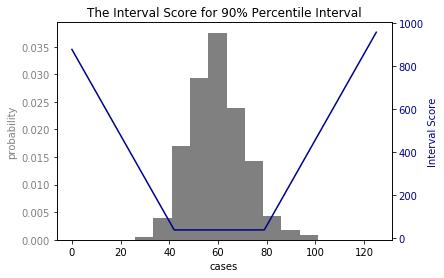

In [13]:
# An example of Using Only a Single Interval Score
a = .1

example_scores_x = np.arange(0,F.max()+25)
example_scores = [interval_score(a, F, y) for y in example_scores_x]

fig, ax1 = plt.subplots()

color = 'gray'
ax1.set_xlabel('cases')
ax1.set_ylabel('probability', color=color)
ax1.hist(F, color=color, density=True)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'darkblue'  
ax2.set_ylabel('Interval Score', color=color)
ax2.plot(example_scores_x, example_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set(title='The Interval Score for 90% Percentile Interval');

In [14]:
def weighted_interval_score(alphas, F, y) -> float:
  """
  The weighted interval score as described in Reich COVID-19 Forecast Hub.
  We are following the nomenclature in the paper for ease of comparison

  Parameters
  ----------
  alphas: list[float]
    A list of alphas to include in central predictive interval tests. All alphas must be in (0,1).
    Do not include the median (alpha=1). If you pass in an empty list we return the point forecast
    interval score, which is just the absolute error.
  F: pandas.Series
    The function to draw quantiles. Can be anything that has a self.quantile method that returns
    a quantile when passed a value in [0,1]
  y: float
    The observed value

  Returns
  -------
  score: float
    The weighted interval score for a given alpha, predictive distribution F, and observed Y. 
  """
  
  # Calculate the absolute error of the median
  w_0 = 1/2
  score_median = w_0 * 2 * abs(y-F.quantile(.5))

  # Calculate the interval scores for each provided alpha
  # Note that the weight is proportial to the alpha/2
  score_individual_intervals = [(a/2)*interval_score(a, F, y) for a in alphas]

  # Calculate the average of all of them
  summed_scores = score_median + sum(score_individual_intervals)
  num_of_intervals = 1 + len(alphas)
  return summed_scores/num_of_intervals

In [78]:
def plot_possible_scores(alphas, F, quantiles):
    possible_observed = np.arange(F.quantile(quantiles[0]) * 0.8, 
                                  F.quantile(quantiles[-1]) * 1.5)
    scores = [weighted_interval_score(alphas, F, y) for y in possible_observed]
    
    fig, ax1 = plt.subplots()
    
    color = 'gray'
    ax1.set_xlabel('cases')
    ax1.set_ylabel('probability', color=color)
    values = F.quantile(quantiles)
    pdf = np.append(quantiles[0], np.diff(quantiles))
    ax1.plot(values, pdf, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'darkblue'
    ax2.set_ylabel('Interval Score', color=color)
    ax2.plot(possible_observed, scores, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set(title=f'The Weighted Interval Score\nfor Median + Alphas = {alphas}')
    return 

In [25]:
from pyseir.cdc.parameters import QUANTILES

In [16]:
# Possible Alpha Calculations
JUST_MEDIAN = []
MEDIAN_PLUS_CI90 = [.1]
FORECAST_HUB = [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

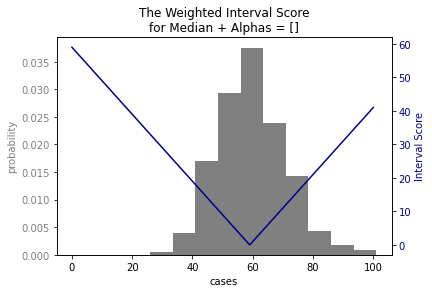

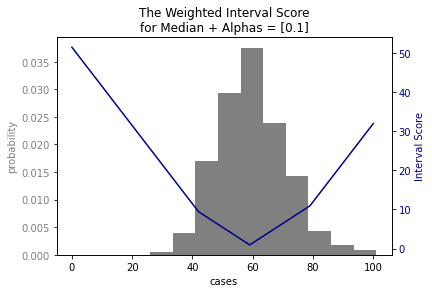

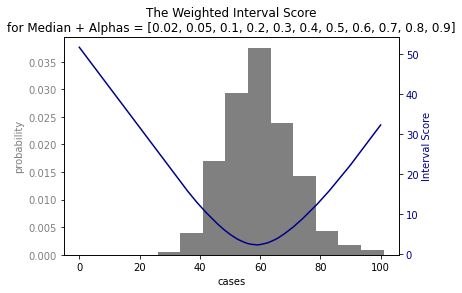

In [8]:
for a in [JUST_MEDIAN, MEDIAN_PLUS_CI90, FORECAST_HUB]:
    plot_possible_scores(a, F, quantiles)

In [57]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
F = quantile_func(fips='06',
                  forecast_date=datetime.strftime((FORECAST_DATE - timedelta(days=1)), DATE_FORMAT),
                  target=Target.CUM_DEATH,
                  unit = ForecastTimeUnit.DAY,
                  n_units=1)

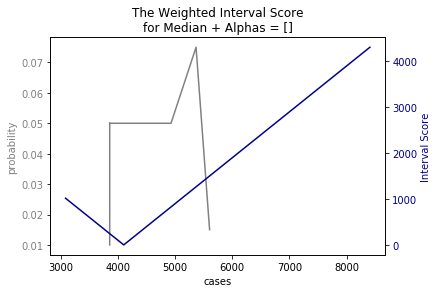

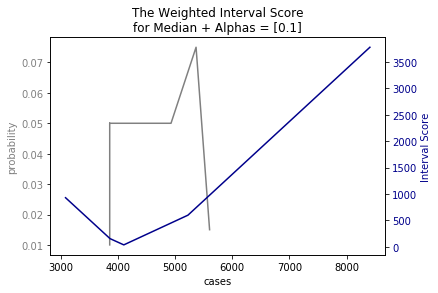

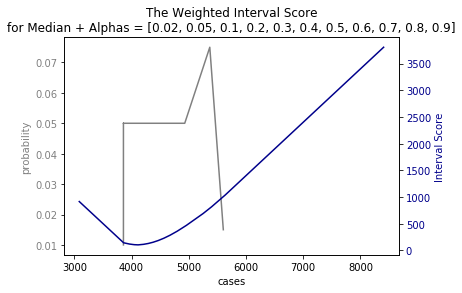

In [79]:
for a in [JUST_MEDIAN, MEDIAN_PLUS_CI90, FORECAST_HUB]:
    plot_possible_scores(a, F, QUANTILES)

In [88]:
from pyseir.cdc.validation import Validation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
v = Validation(fips='06', 
               forecast_date = datetime.today() - timedelta(days=10))

Did not match 50 counties to fips data.
                                                   county state  \
215                                       Alexandria City    VA   
216                                       Alexandria City    VA   
217                                       Alexandria City    VA   
218                                       Alexandria City    VA   
219                                       Alexandria City    VA   
...                                                   ...   ...   
187034  Yakutat City and Borough, Skagway Municipality...    AK   
187035  Yakutat City and Borough, Skagway Municipality...    AK   
187036  Yakutat City and Borough, Skagway Municipality...    AK   
187037  Yakutat City and Borough, Skagway Municipality...    AK   
187038  Yakutat City and Borough, Skagway Municipality...    AK   

                                            name   level city country  \
215     Alexandria City, Virginia, United States  county  NaN     USA   
216     A

ERROR:root:Removing duplicates: [False False False ... False False False]


ValueError: ForecastTimeUnit.DAY is not implemented

In [92]:
v.extract_quantiles

NameError: name 'v' is not defined